In [4]:
# all used imoorts
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error

In [5]:
#configure TensorFlow to limit VRAM usage

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)]  # MB
        )
        print("VRAM limited to 100 MB.")
    except RuntimeError as e:
        print("Memory configuration must be set at program start:", e)

VRAM limited to 100 MB.


2025-06-02 11:33:02.150174: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 11:33:04.594060: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 11:33:04.594133: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
# Used Functions

#used to load and clean the csv files
def load_and_clean_csv(path):
    df = pd.read_csv(path)
    
    # Drop last 6 rows
    df = df.iloc[:-6]
    
    # Convert date column to datetime
    df['#date+time'] = pd.to_datetime(df['#date+time'], errors='coerce')
    df = df.rename(columns={'#date+time': 'date_time'})
    
    # Convert all other columns to numeric
    for col in df.columns:
        if col != 'date_time':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df
# Function to convert wind speed and direction to U/V components

def wind_to_uv(speed, direction_deg):
    # Convert to radians
    direction_rad = np.deg2rad(direction_deg)

    # U = -speed * sin(direction), V = -speed * cos(direction)

    u = -speed * np.sin(direction_rad)
    v = -speed * np.cos(direction_rad)
    return u, v

# Function to prepare the DataFrame for model input
def prepare_dataframe(df):
    # Rename columns to a consistent format
    df = df.rename(columns={
        df.columns[0]: 'date_time',
        df.columns[1]: 'pwl',
        df.columns[2]: 'wsd',
        df.columns[3]: 'wdr'
    })
    
    # Convert wind to U/V components
    u, v = wind_to_uv(df['wsd'], df['wdr'])
    df[['u', 'v']] = np.column_stack((u, v))
    
    # Drop raw wind columns
    df.drop(columns=['wsd', 'wdr'], inplace=True)
    
    return df
# Function to create input and output arrays for the model
def input_output_arrays(pl_df, po_df, wl_window, wind_window):

    wl_window = wl_window * 10
    wind_window = wind_window * 10

    pl_df = pl_df.reset_index(drop=True)
    po_df = po_df.reset_index(drop=True)

    pl_pwl = pl_df['pwl'].to_numpy()
    pl_u   = pl_df['u'].to_numpy()
    pl_v   = pl_df['v'].to_numpy()
    po_pwl = po_df['pwl'].to_numpy()

    X, y, indices = [], [], []

    for t in range(max(wl_window, wind_window), len(pl_df) - wl_window):
        # Water level window: centered at t
        wl_slice = slice(t - wl_window, t + wl_window + 1)

        # Wind window: past `wind_window` values ending at t
        wind_slice = slice(t - wind_window + 1, t + 1)

        pwl_input = pl_pwl[wl_slice]
        u_input = pl_u[wind_slice]
        v_input = pl_v[wind_slice]
        target = po_pwl[t]

        if (
            np.isnan(pwl_input).any() or
            np.isnan(u_input).any() or
            np.isnan(v_input).any() or
            np.isnan(target)
        ):
            continue

        features = np.concatenate([pwl_input, u_input, v_input])
        X.append(features)
        y.append(target)
        indices.append(t)

    return np.array(X), np.array(y), np.array(indices)

file_paths = {
    'po11': '/home/ryan/Downloads/po_2011-2012.csv',
    'pl11': '/home/ryan/Downloads/pl_2011-2012.csv',
    'po13': '/home/ryan/Downloads/po_2013-2014.csv',
    'pl13': '/home/ryan/Downloads/pl_2013-2014.csv',
    'po15': '/home/ryan/Downloads/po_2015-2016.csv',
    'pl15': '/home/ryan/Downloads/pl_2015-2016.csv',
}
# Function to calculate the percentage of predictions with a central frequency (CF)
def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage

# Function to evaluate the model on the testing data
def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)

datasets = {key: load_and_clean_csv(path) for key, path in file_paths.items()}

for name, df in datasets.items():
    datasets[name] = prepare_dataframe(df)


/tmp/ipykernel_248698/823489.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_248698/823489.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [7]:
datasets['po11']

,date_time,pwl,u,v
0,2011-11-01 00:00:00,3.493,-4.414738,2.347358
1,2011-11-01 00:06:00,3.495,-4.792432,1.744303
2,2011-11-01 00:12:00,3.498,-4.673729,2.279530
3,2011-11-01 00:18:00,3.504,-4.633234,2.360751
4,2011-11-01 00:24:00,3.509,-4.633234,2.360751
...,...,...,...,...
182873,2013-12-01 23:18:00,3.640,0.167246,1.591235
182874,2013-12-01 23:24:00,3.645,-0.219510,2.088496
182875,2013-12-01 23:30:00,3.647,0.167246,1.591235
182876,2013-12-01 23:36:00,3.655,0.523711,1.826397


In [8]:
# create input and output arrays for training, validation, and testing

X_train, y_train, indices_train = input_output_arrays(datasets['pl11'], datasets['po11'], wl_window=2, wind_window=2)
X_valid, y_valid, indices_valid = input_output_arrays(datasets['pl13'], datasets['po13'], wl_window=2, wind_window=2)
X_test, y_test, indices_test = input_output_arrays(datasets['pl15'], datasets['po15'], wl_window=2, wind_window=2)

print(X_train.shape, y_train.shape)

(167924, 81) (167924,)


In [ ]:
model_file_name = 'plpo.keras'
batch_size = len(X_train)
inputs = X_train.shape[1]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(inputs,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, kernel_initializer= 'normal')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

epochs = 1000
validation_batch_size = len(X_valid)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

callbacks = [early_stopping, checkpoint]

model_history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

model.summary()

2025-06-02 11:33:09.111810: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 11:33:09.111944: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 11:33:09.111997: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 11:33:09.112076: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-02 11:33:09.112131: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Epoch 1/1000


I0000 00:00:1748881990.548327  249798 service.cc:146] XLA service 0x7feef0207aa0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748881990.548362  249798 service.cc:154]   StreamExecutor device (0): Radeon RX 7900 GRE, AMDGPU ISA version: gfx1100
2025-06-02 11:33:10.561956: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 15.8594 - mae: 3.9697

I0000 00:00:1748881995.316303  249798 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 14.48162, saving model to plpo.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 15.8594 - mae: 3.9697 - val_loss: 14.4816 - val_mae: 3.7942
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 14.8890 - mae: 3.8453
Epoch 2: val_loss improved from 14.48162 to 13.66857, saving model to plpo.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 14.8890 - mae: 3.8453 - val_loss: 13.6686 - val_mae: 3.6840
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 13.9765 - mae: 3.7233
Epoch 3: val_loss improved from 13.66857 to 12.90080, saving model to plpo.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 13.9765 - mae: 3.7233 - val_loss: 12.9008 - val_mae: 3.5757
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 13.1100 - mae: 3.6025
Epoch 4: val_loss improved from 12.90080 to 12.17666, saving model to plpo.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 13.1100 - mae: 3.6025 - val_loss: 12.1767 - val_mae: 3.4693
Epoch 5/1000

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,985 (19.48 KB)

 Trainable params: 1,661 (6.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,324 (12.99 KB)

In [10]:
evaluate_model(model, X_valid, y_valid)


Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1212 - mae: 0.2737
Loss: [0.12124354392290115, 0.2736665606498718]

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step

Central Frequency Percentage 15cm: 34.27867878067419

Central Frequency Percentage 5cm: 11.85573575613484

Central Frequency Percentage 1cm: 2.362656024454445
Mean Squared Error: 0.12124355433871768
Root Mean Squared Error: 0.34820045137638417
Mean Absolute Error: 0.2736665447765632
Median Absolute Error: 0.2288742275238036
R-squared: -4.290375770644729


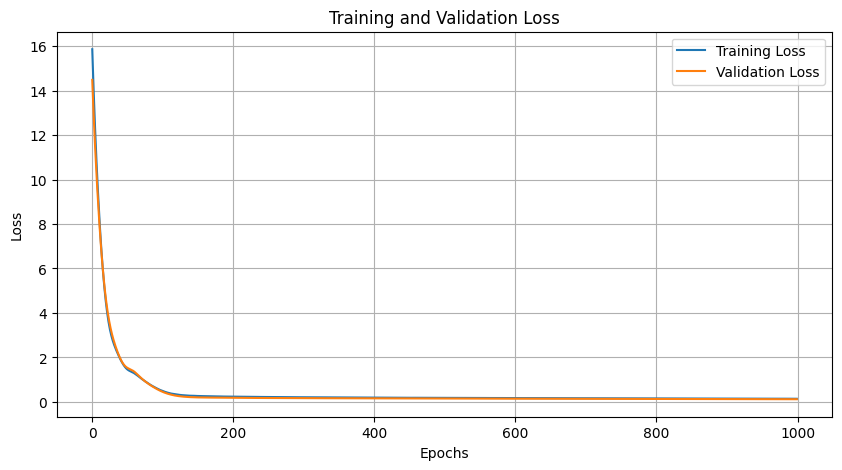

In [11]:
#plotting validation and training loss
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


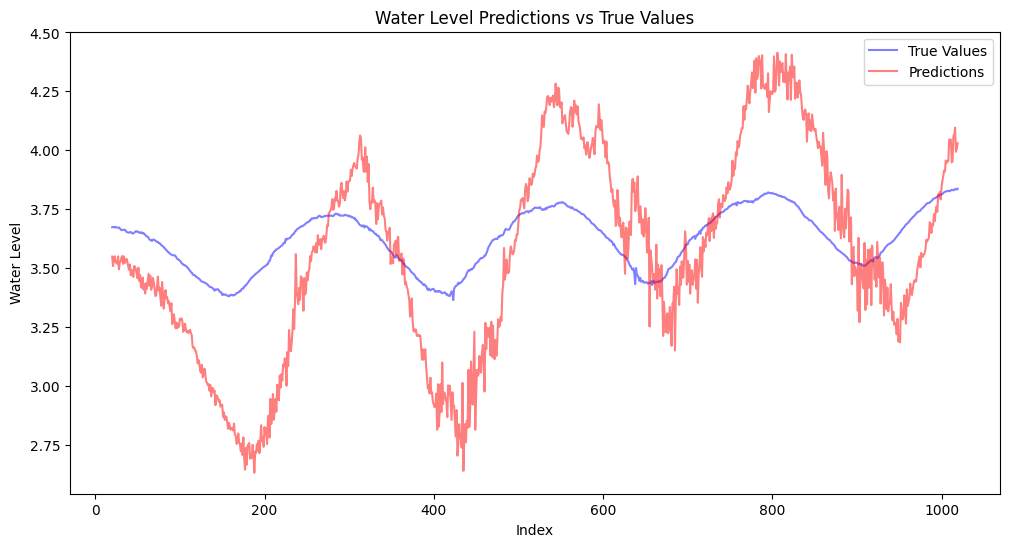

In [12]:
# plotting predictions vs true values
predictions = model.predict(X_valid, batch_size = len(X_valid))
plt.figure(figsize=(12, 6))
plt.plot(indices_valid[0:1000], y_valid[0:1000], label='True Values', color='blue', alpha=0.5)
plt.plot(indices_valid[0:1000], predictions[0:1000], label='Predictions', color='red', alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Water Level')
plt.title('Water Level Predictions vs True Values')
plt.legend()
plt.show()